In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # Import path effects for text outline
import pandas as pd
from utils import *

In [2]:
# avg_power 378.8556695697469 std_power 3.631425271401822

# avg_power 93.54626298542978 std_power 2.497080950805588
# avg_power 93.95008267753535 std_power 2.7211928636453404

BASE_MEAN_mW = 378.8556695697469
BASE_STD_mW = 3.631425271401822

SMALL_MEAN_mW = 93.54626298542978
SMALL_STD_mW = 2.497080950805588

BART_MEAN_mW = 93.95008267753535
BART_STD_mW = 2.7211928636453404

### RUN PLOTTING

In [3]:
# Load task records from the CSV file
file_path_no_dare_no_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
file_path_no_dare_yes_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
file_path_yes_dare_no_session = '../results/10_users_3_tasks/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

# file_path = file_path_no_dare_no_session
file_path = file_path_no_dare_yes_session
# file_path = file_path_yes_dare_no_session

task_records = load_task_records(file_path)

if task_records is None:
    print("Failed to load task records. Exiting.")

In [4]:
calculate_total_waiting_time(task_records)

(np.float64(21.040813875198364),
 np.float64(18.036011511969086),
 np.float64(841.6325550079346))

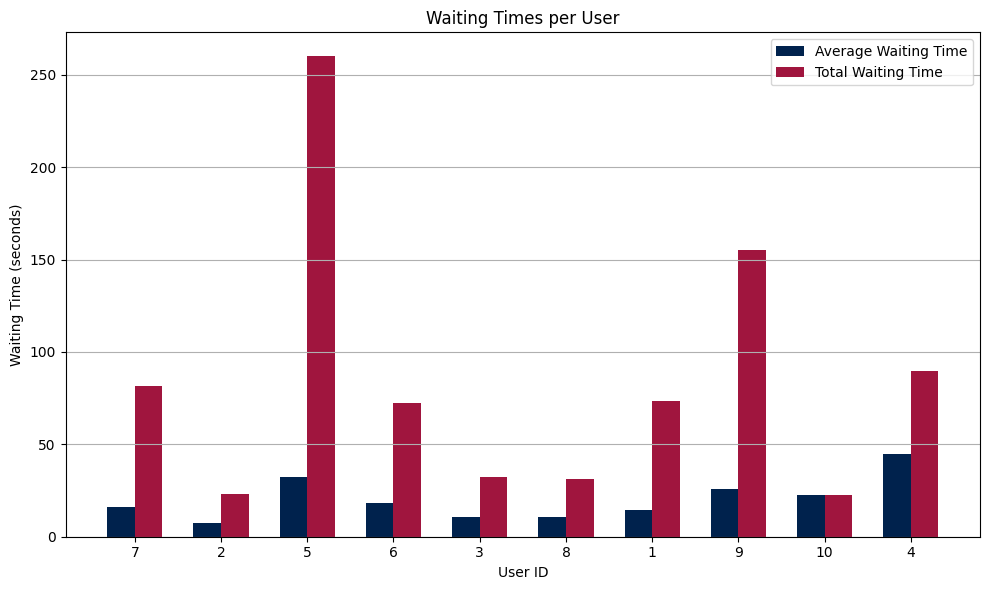

In [5]:
plot_waiting_times(task_records)

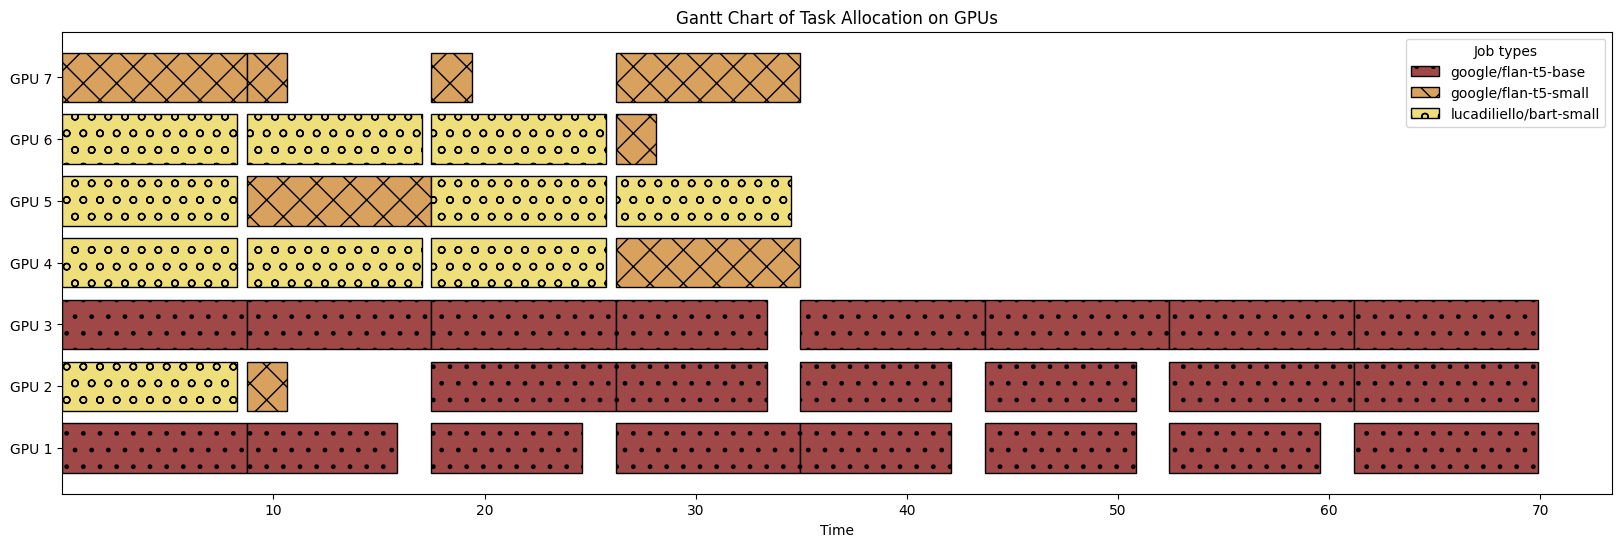

In [6]:
generate_gantt_gantt_executions(task_records)

<class 'numpy.ndarray'>
GPU 1 Tasks: 8, Total Training Time: 61.875489407910784, Unique Users: 6
GPU 2 Tasks: 8, Total Training Time: 57.795085747404066, Unique Users: 6
GPU 3 Tasks: 8, Total Training Time: 68.25978719432575, Unique Users: 4
GPU 4 Tasks: 4, Total Training Time: 33.57996997245287, Unique Users: 4
GPU 5 Tasks: 4, Total Training Time: 33.57996997245287, Unique Users: 4
GPU 6 Tasks: 4, Total Training Time: 26.756737701409293, Unique Users: 3
GPU 7 Tasks: 4, Total Training Time: 21.28146627837759, Unique Users: 4


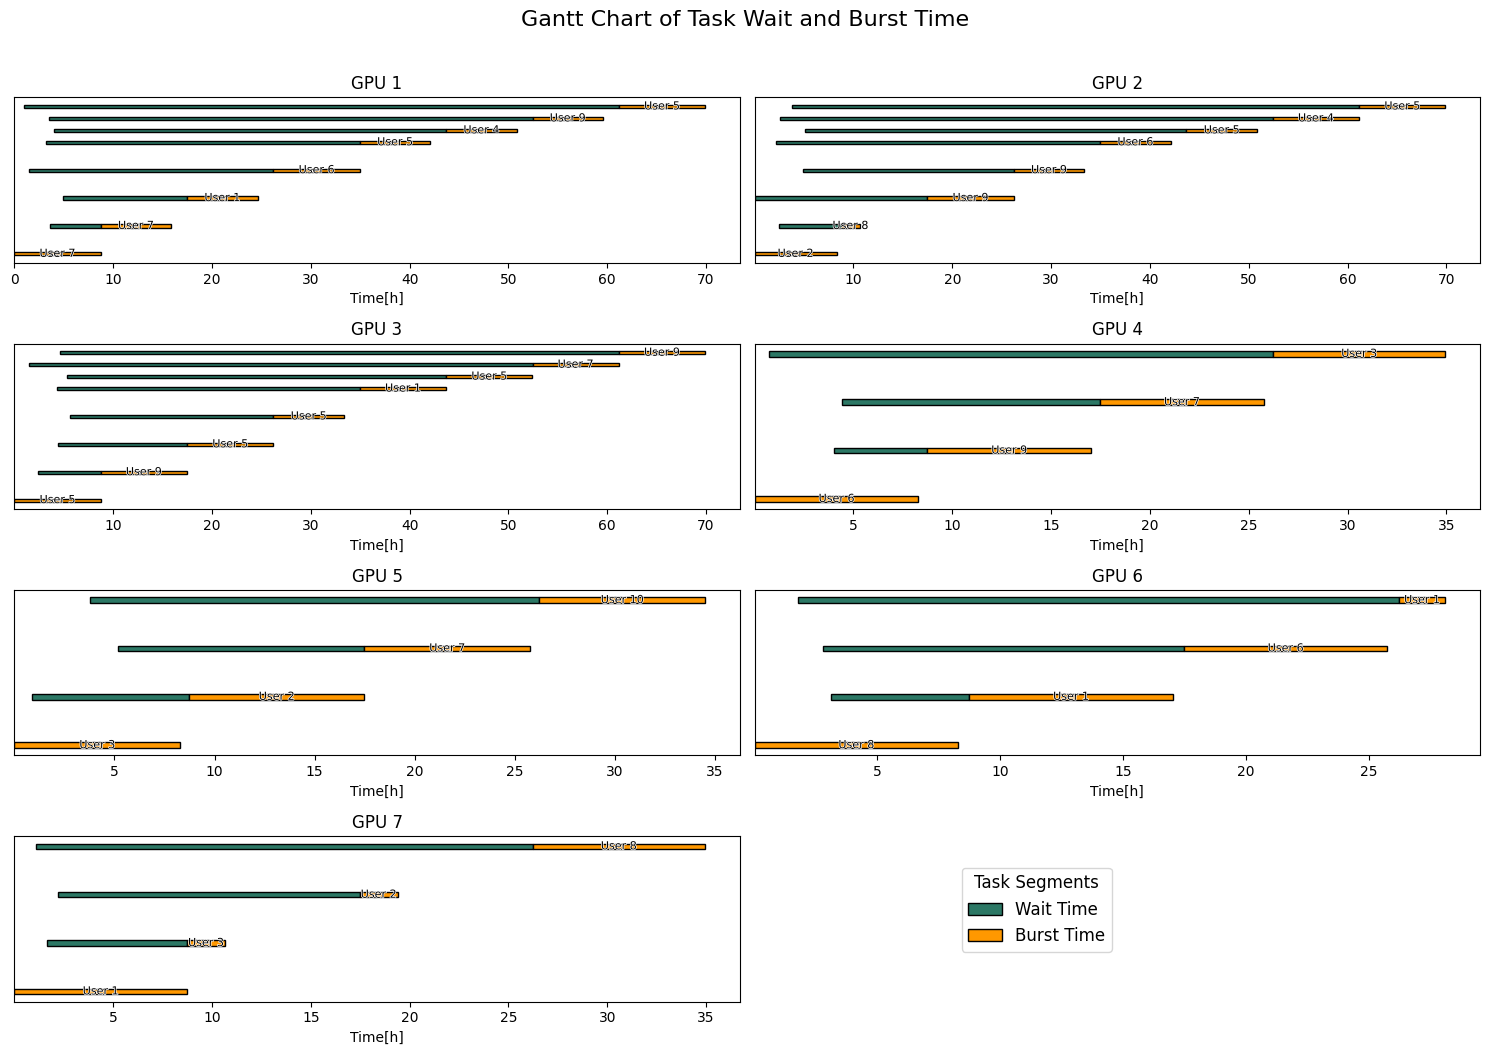

In [7]:
generate_gantt_arrival_ending_time(task_records)

### BENCHMARK

Users:  1
Total waiting time no_dare_no_session:  0.0007500648498535156
Total waiting time no_dare_yes_session:  17.07095718383789
Total waiting time yes_dare_no_session:  9.93464708328247
Users:  5
Total waiting time no_dare_no_session:  62.04605984687805
Total waiting time no_dare_yes_session:  221.2774076461792
Total waiting time yes_dare_no_session:  67.46844267845154
Users:  10
Total waiting time no_dare_no_session:  358.8631374835968
Total waiting time no_dare_yes_session:  841.6325550079346
Total waiting time yes_dare_no_session:  294.89185523986816
Users:  15
Total waiting time no_dare_no_session:  657.1466042995453
Total waiting time no_dare_yes_session:  1549.1464672088623
Total waiting time yes_dare_no_session:  501.0374450683594
Users:  30
Total waiting time no_dare_no_session:  2651.3994953632355
Total waiting time no_dare_yes_session:  6570.373398303986
Total waiting time yes_dare_no_session:  2303.9945743083954


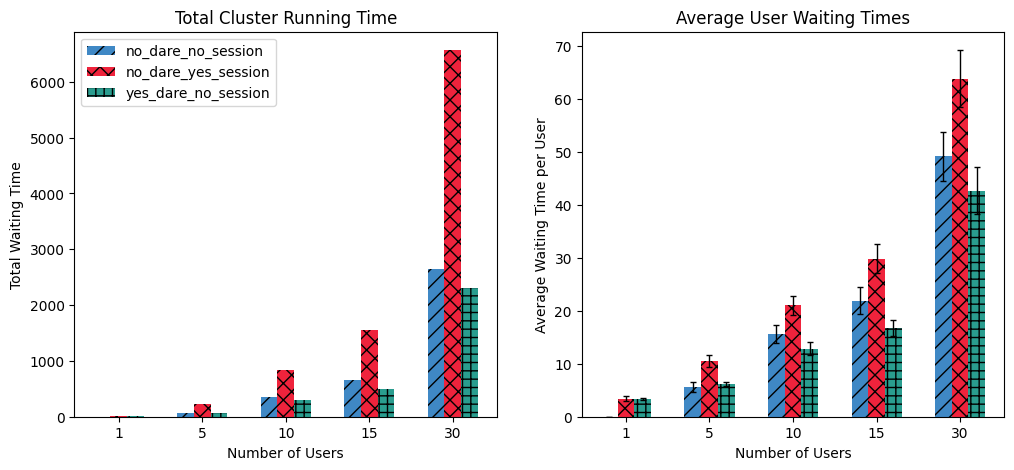

In [8]:
number_of_user = [1, 5, 10, 15, 30]

n_clusters = len(number_of_user)

# Bar width and positions
bar_width = 0.2
x = np.arange(n_clusters)

titles = ['Total Cluster Running Time', 'Average User Waiting Times']

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

totals_no_dare_no_session = []
totals_no_dare_yes_session = []
totals_yes_dare_no_session = []

average_per_user_no_dare_no_session = []
average_per_user_no_dare_yes_session = []
average_per_user_yes_dare_no_session = []

std_per_user_no_dare_no_session = []
std_per_user_no_dare_yes_session = []
std_per_user_yes_dare_no_session = []

colors = [ "#3f88c5", "#ef233c", "#2a9d8f", "#2a9d8f", "#f4a261", "#264653"]
hatch = ['//', 'xx', '++', '-', '|', 'o']

for n_users in number_of_user:
    # Load task records from the CSV file
    file_path_no_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
    file_path_no_dare_yes_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
    file_path_yes_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

    task_records_no_dare_no_session = load_task_records(file_path_no_dare_no_session)
    task_records_no_dare_yes_session = load_task_records(file_path_no_dare_yes_session)
    task_records_yes_dare_no_session = load_task_records(file_path_yes_dare_no_session)

    results_no_dare_no_session = calculate_total_waiting_time(task_records_no_dare_no_session)
    results_no_dare_yes_session = calculate_total_waiting_time(task_records_no_dare_yes_session)
    results_yes_dare_no_session = calculate_total_waiting_time(task_records_yes_dare_no_session)

    print("Users: ", n_users)
    print("Total waiting time no_dare_no_session: ", results_no_dare_no_session[2])
    print("Total waiting time no_dare_yes_session: ", results_no_dare_yes_session[2])
    print("Total waiting time yes_dare_no_session: ", results_yes_dare_no_session[2])

    totals_no_dare_no_session.append(results_no_dare_no_session[2])
    totals_no_dare_yes_session.append(results_no_dare_yes_session[2])
    totals_yes_dare_no_session.append(results_yes_dare_no_session[2])

    average_per_user_no_dare_no_session.append(results_no_dare_no_session[0])
    average_per_user_no_dare_yes_session.append(results_no_dare_yes_session[0])
    average_per_user_yes_dare_no_session.append(results_yes_dare_no_session[0])

    std_per_user_no_dare_no_session.append(results_no_dare_no_session[1])
    std_per_user_no_dare_yes_session.append(results_no_dare_yes_session[1])
    std_per_user_yes_dare_no_session.append(results_yes_dare_no_session[1])

totals = [totals_no_dare_no_session, totals_no_dare_yes_session, totals_yes_dare_no_session]
average_per_user = [average_per_user_no_dare_no_session, average_per_user_no_dare_yes_session, average_per_user_yes_dare_no_session]
std_per_user = [std_per_user_no_dare_no_session, std_per_user_no_dare_yes_session, std_per_user_yes_dare_no_session]

# Create a bar chart for each subplot

for i, data in enumerate(totals):
    axes[0].bar(x + i * bar_width, data, bar_width,  label=['no_dare_no_session', 'no_dare_yes_session', 'yes_dare_no_session'][i], color=colors[i], hatch=hatch[i])

for i, _ in enumerate(average_per_user):
    # axes[1].bar(x + i * bar_width, data, bar_width,  label=['no_dare_no_session', 'no_dare_yes_session', 'yes_dare_no_session'][i])
    avg = average_per_user[i]
    std = [s / 10 for s in std_per_user[i]]

    axes[1].bar(x + i * bar_width, avg, bar_width,  label=['no_dare_no_session', 'no_dare_yes_session', 'yes_dare_no_session'][i], yerr=std, error_kw=dict(lw=1, capsize=2, capthick=1, color="gray"), color=colors[i], hatch=hatch[i])
   
axes[0].set_title(titles[0])
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Total Waiting Time')
axes[0].set_xticks(x + bar_width)
axes[0].set_xticklabels(number_of_user)
axes[0].legend()

axes[1].set_title(titles[1])
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Average Waiting Time per User')
axes[1].set_xticks(x + bar_width)
axes[1].set_xticklabels(number_of_user)
# axes[1].legend()

# Show the plot
plt.show()
                                                

In [19]:
import pandas as pd
import numpy as np

def calculate_avg_jct(task_records):
    """
    Calculate the average job completion time (AvgJCT) from a DataFrame of task records.
    
    Parameters:
    task_records (pd.DataFrame): A DataFrame with 'Arrival_Time' and 'End_Time' columns.
    
    Returns:
    float: The average job completion time.
    """
    # Calculate completion times for each task
    completion_times = task_records['End_Time'] - task_records['Arrival_Time']
    
    # Calculate the average completion time
    avg_jct = completion_times.mean()
    
    return avg_jct

def calculate_jct_std(task_records):
    """
    Calculate the standard deviation of job completion times (JCT) from a DataFrame of task records.
    
    Parameters:
    task_records (pd.DataFrame): A DataFrame with 'Arrival_Time' and 'End_Time' columns.
    
    Returns:
    float: The standard deviation of job completion times.
    """
    # Calculate completion times for each task
    completion_times = task_records['End_Time'] - task_records['Arrival_Time']
    
    # Calculate the standard deviation of completion times
    jct_std = completion_times.std(ddof=1)  # Using sample standard deviation
    
    return jct_std


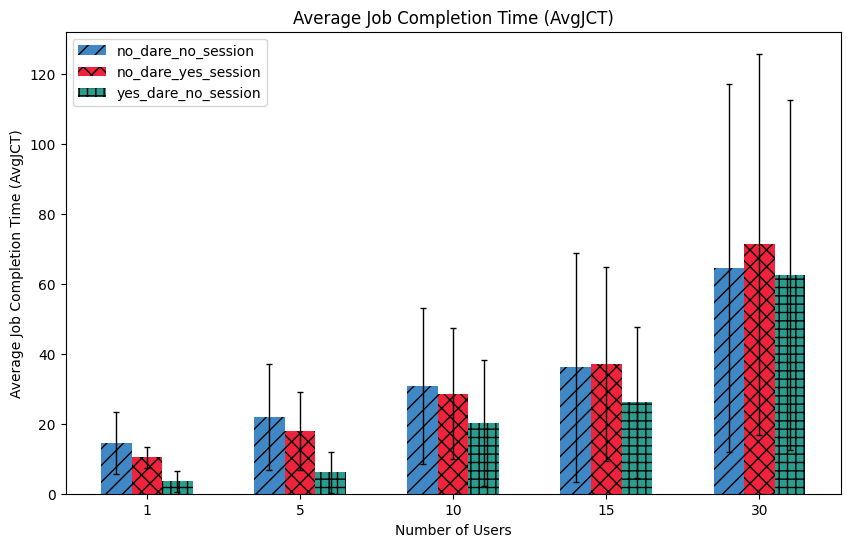

In [23]:
import numpy as np
import matplotlib.pyplot as plt

number_of_user = [1, 5, 10, 15, 30]
n_clusters = len(number_of_user)

# Bar width and positions
bar_width = 0.2
x = np.arange(n_clusters)

# Titles and settings for plotting
title = 'Average Job Completion Time (AvgJCT)'

# Data lists for each configuration
avg_jct_no_dare_no_session = []
avg_jct_no_dare_yes_session = []
avg_jct_yes_dare_no_session = []

std_jct_no_dare_no_session = []
std_jct_no_dare_yes_session = []
std_jct_yes_dare_no_session = []

colors = ["#3f88c5", "#ef233c", "#2a9d8f"]
hatch = ['//', 'xx', '++']

for n_users in number_of_user:
    # Load task records from the CSV files
    file_path_no_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'
    file_path_no_dare_yes_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'
    file_path_yes_dare_no_session = f'../results/{n_users}_users_3_tasks/task_records_users_{n_users}_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'

    task_records_no_dare_no_session = load_task_records(file_path_no_dare_no_session)
    task_records_no_dare_yes_session = load_task_records(file_path_no_dare_yes_session)
    task_records_yes_dare_no_session = load_task_records(file_path_yes_dare_no_session)

    # Calculate AvgJCT and standard deviation for each configuration
    avg_jct_no_dare_no_session.append(calculate_avg_jct(task_records_no_dare_no_session))
    avg_jct_no_dare_yes_session.append(calculate_avg_jct(task_records_no_dare_yes_session))
    avg_jct_yes_dare_no_session.append(calculate_avg_jct(task_records_yes_dare_no_session))

    std_jct_no_dare_no_session.append(calculate_jct_std(task_records_no_dare_no_session))
    std_jct_no_dare_yes_session.append(calculate_jct_std(task_records_no_dare_yes_session))
    std_jct_yes_dare_no_session.append(calculate_jct_std(task_records_yes_dare_no_session))

# Organize data for plotting
avg_jct = [avg_jct_no_dare_no_session, avg_jct_no_dare_yes_session, avg_jct_yes_dare_no_session]
std_jct = [std_jct_no_dare_no_session, std_jct_no_dare_yes_session, std_jct_yes_dare_no_session]

# Create a bar chart for Average Job Completion Time (AvgJCT)
plt.figure(figsize=(10, 6))

for i, avg in enumerate(avg_jct):
    plt.bar(x + i * bar_width, avg, bar_width, 
            label=['no_dare_no_session', 'no_dare_yes_session', 'yes_dare_no_session'][i], 
            yerr=std_jct[i], error_kw=dict(lw=1, capsize=2, capthick=1, color="gray"), 
            color=colors[i], hatch=hatch[i])

# Set plot titles, labels, and legends
plt.title(title)
plt.xlabel('Number of Users')
plt.ylabel('Average Job Completion Time (AvgJCT)')
plt.xticks(x + bar_width, number_of_user)
plt.legend()

# Show the plot
plt.show()
